# Semantic segmentation of lungs in X-ray images



Importing libraries:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import os
import tensorflow as tf
#from tensorflow import keras
import matplotlib.pyplot as plt # data visualization
import cv2 # for image manipulation and visualization
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import time
!pip install imutils
from imutils import paths

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=b58f9ad9e0d7604b91c72716a1f6cba0124d97498ea6ddab0d403709285187b9
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [3]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#print(physical_devices)

# **Loading, cleaning and ordering of data**

Dataset source: 
 Jaeger S, Karargyris A, Candemir S, Folio L, Siegelman J, Callaghan F, Xue Z, Palaniappan K, Singh RK, Antani S, Thoma G, Wang YX, Lu PX, McDonald CJ. Automatic tuberculosis screening using chest radiographs. IEEE Trans Med Imaging. 2014 Feb;33(2):233-45. doi: 10.1109/TMI.2013.2284099. PMID: 24108713
Candemir S, Jaeger S, Palaniappan K, Musco JP, Singh RK, Xue Z, Karargyris A, Antani S, Thoma G, McDonald CJ. Lung segmentation in chest radiographs using anatomical atlases with nonrigid registration. IEEE Trans Med Imaging. 2014 Feb;33(2):577-90. doi: 10.1109/TMI.2013.2290491. PMID: 24239990
Montgomery County X-ray Set


In [4]:
image_path = '../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/'
mask_path = '../input/chest-xray-masks-and-labels/Lung Segmentation/masks/'

In [5]:
image_names = list(paths.list_images(image_path)) 
mask_names = list(paths.list_images(mask_path)) 
image_names[:2] # displaying a couple of examples of image names

['../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/CHNCXR_0092_0.png',
 '../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/CHNCXR_0322_0.png']

In [6]:
print('Number of images: ' + str(len(image_names)))
print('Number of masks (labels): ' + str(len(mask_names)))

Number of images: 800
Number of masks (labels): 704


Some of the images in the dataset are missing their labels! 
This problem is resolved by removing those images from the dataset with the following snippet of code.

In [8]:
mask_names_base = [ name.split('_mask.png')[0] for name in mask_names ] # extracting the common part of the mask file names
image_names_reduced = [ name + '.png' for name in mask_names_base ] # adding the .png extension suffix
image_names_reduced = [ name.replace('masks','CXR_png', -1) for name in image_names_reduced ] # replacing the sufffix
image_names_reduced = [ name.replace('CXR_png','masks', 1) for name in image_names_reduced ] # 'masks' sometimes also appears in an earlier part of the name 
image_names_reduced = [ name.replace('.png.png','.png', -1) for name in image_names_reduced ] # a small amount of images had .png in their name twice so i fixed it with this
print('number of images that have labels: ' + str(len(image_names_reduced)))

number of images that have labels: 704


## **Reducing image size:**

In [9]:
size = (256, 256)
def image_resize(img):
    return cv2.resize(img,size)

**Uređivanje podataka u format oblika (broj slika, širina slike, visina slike, kanali):**

In [10]:
x = np.array([ image_resize(cv2.imread(name)) for name in image_names_reduced ])
print(x.shape)

(704, 256, 256, 3)


In [11]:
y = np.array([ image_resize(cv2.imread(name)) for name in mask_names ])
print(y.shape)

(704, 256, 256, 3)


# Data splitting and normalization

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

x_train_norm = x_train/255.
x_test_norm = x_test/255.

y_train_norm = (y_train/255. > 0.5).astype(int)
y_test_norm = (y_test/255. > 0.5).astype(int)

# Vizuelizacija snimaka i maski

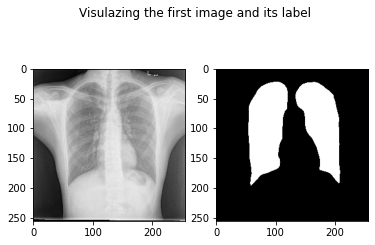

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Visulazing the first image and its label')
ax1.imshow(x[0,:,:,:])
ax2.imshow(y[0,:,:,:])

# 1) U-Net model
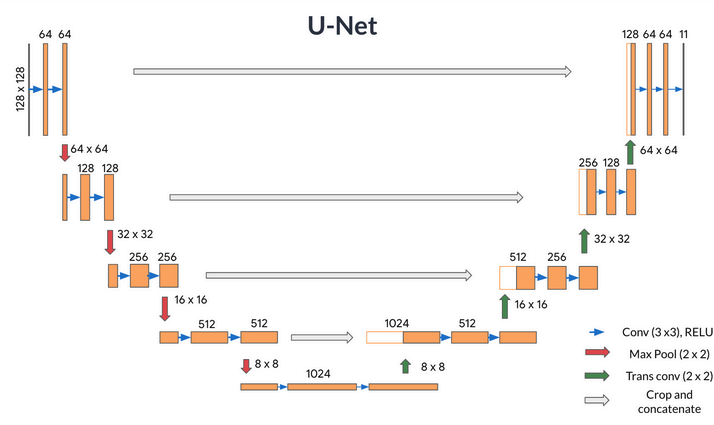


short descripcion coming soon :)

# Convolutional block

A block that is repeated multiple times and consists of two (3,3, 'same') convolutional filters with relu activation.


In [19]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, kernel_size = (3,3), padding = 'same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size = (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# Encoder
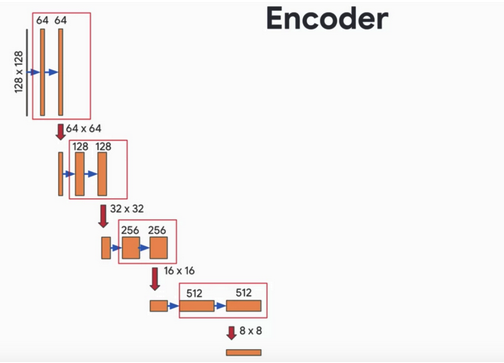

**Encoder block**

In [20]:
def enc_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

# Dekoderski blok
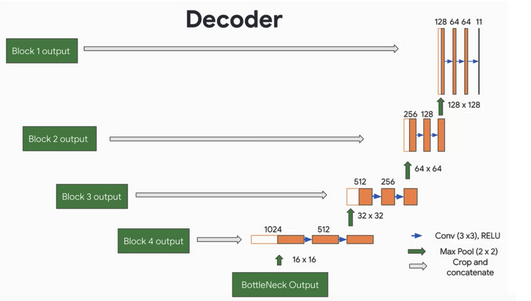

In [22]:
def dec_block(input, skip_input, num_filters):
    x = Conv2DTranspose(num_filters,(2,2), strides = 2, padding = 'same')(input)
    x = Concatenate()([x, skip_input])
    x = conv_block(x, num_filters)
    return x

# U-Net model

In [23]:
def unet(input_shape):
    inputs = Input(input_shape)
    
    s1, p1 = enc_block(inputs, 64)
    s2, p2 = enc_block(p1, 128)
    s3, p3 = enc_block(p2, 256)
    s4, p4 = enc_block(p3, 512)
    
    b1= conv_block(p4,1024) 
    
    d1 = dec_block(b1, s4, 512)
    d2 = dec_block(d1, s3, 256)
    d3 = dec_block(d2, s2, 128)
    d4 = dec_block(d3, s1, 64)
    
    outputs = Conv2D(filters=3, kernel_size = (1,1), padding = 'same', activation = 'sigmoid')(d4)
    
    u_net_model = Model(inputs=inputs,outputs=outputs, name='U-Net')
    
    return u_net_model

** model creation:  **

In [26]:
input_shape=(256,256,3)
model_UNet = unet(input_shape)
#model_UNet.summary() #uncomment for model summary

# Neural net compiling and training

In [27]:
#os.makedirs('./files', exist_ok=True)
#csv_path='./files'
model_UNet.compile(optimizer='adam',
                  loss = 'binary_crossentropy',
                  )
callbacks = [
    #ModelCheckpoint('mod3', verbose=1, save_best_only=False),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-7, verbose=1),
    #CSVLogger('loger4', separator = ',', append = False)
    ]

In [28]:
start_time = time.time()
history = model_UNet.fit(
        x_train_norm, y_train_norm,
        epochs=30,
        batch_size=16,
        validation_data = (x_test_norm, y_test_norm),
        callbacks=callbacks
    )
end_time = time.time()
final_time = end_time - start_time
print(final_time)

2023-01-16 13:02:11.544228: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 442761216 exceeds 10% of free system memory.
2023-01-16 13:02:12.059514: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 885522432 exceeds 10% of free system memory.
2023-01-16 13:02:13.147596: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 442761216 exceeds 10% of free system memory.
2023-01-16 13:02:13.517913: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 885522432 exceeds 10% of free system memory.
2023-01-16 13:02:14.296432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-01-16 13:02:17.622687: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


36/36 [==============================] - 31s 531ms/step - loss: 0.2651 - val_loss: 24.5626
Epoch 2/30
36/36 [==============================] - 16s 436ms/step - loss: 0.1138 - val_loss: 20.2703
Epoch 3/30
36/36 [==============================] - 16s 435ms/step - loss: 0.0880 - val_loss: 4.4562
Epoch 4/30
36/36 [==============================] - 16s 434ms/step - loss: 0.0732 - val_loss: 0.2870
Epoch 5/30
36/36 [==============================] - 16s 435ms/step - loss: 0.0955 - val_loss: 7.8615
Epoch 6/30
36/36 [==============================] - 16s 434ms/step - loss: 0.0805 - val_loss: 3.7854
Epoch 7/30
36/36 [==============================] - 16s 434ms/step - loss: 0.0662 - val_loss: 0.4327
Epoch 8/30
36/36 [==============================] - 16s 435ms/step - loss: 0.0598 - val_loss: 0.5406

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/30
36/36 [==============================] - 16s 435ms/step - loss: 0.0557 - val_loss: 0.6496
Epoch 10/30
36/36 

## Some resulst

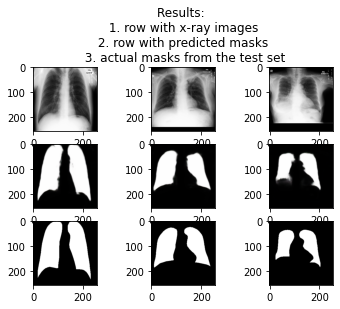

In [38]:
pred0 = model_UNet.predict(x_test_norm)[0]
pred1 = model_UNet.predict(x_test_norm)[1]
pred2 = model_UNet.predict(x_test_norm)[2]


plt.subplot(3, 3, 1)
plt.imshow(x_test_norm[0])

plt.subplot(3, 3, 2)
plt.imshow(x_test_norm[1])

plt.title('Results: \n 1. row with x-ray images \n 2. row with predicted masks \n 3. actual masks from the test set')

plt.subplot(3, 3, 3)
plt.imshow(x_test_norm[2])

plt.subplot(3, 3, 4)
plt.imshow(pred0)

plt.subplot(3, 3, 5)
plt.imshow(pred1)

plt.subplot(3, 3, 6)
plt.imshow(pred2)

plt.subplot(3, 3, 7)
plt.imshow(y_test[0])

plt.subplot(3, 3, 8)
plt.imshow(y_test[1])

plt.subplot(3, 3, 9)
plt.imshow(y_test[2])

plt.show() 

In [ ]:
model_UNet.save_weights('model1')

# 2) Unet with transfer learning from VGG19 network trained with imagenet

inspired by: https://pubmed.ncbi.nlm.nih.gov/31535731/

**loading in the pretrained vgg19 model:**

In [30]:
VGG19 = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)

80150528/80134624 [==============================] - 0s 0us/step


In [39]:
#VGG19.summary()

combining the vgg19 network with the U-net architecture:

In [31]:
def vgg19_unet(input_shape):
    
    inputs = Input(input_shape)
    
    vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs
    )
    
    s1 = vgg19.get_layer('block1_conv2').output
    s2 = vgg19.get_layer('block2_conv2').output
    
    p2 = vgg19.get_layer('block2_pool').output
    
    s3, p3 = enc_block(p2, 256)
    s4, p4 = enc_block(p3, 512)
    
    b1= conv_block(p4,1024) 
    
    d1 = dec_block(b1, s4, 512)
    d2 = dec_block(d1, s3, 256)
    d3 = dec_block(d2, s2, 128)
    d4 = dec_block(d3, s1, 64)
    
    outputs = Conv2D(filters=3, kernel_size = (1,1), padding = 'same', activation = 'sigmoid')(d4)
    
    vgg19u_net_model = Model(inputs=inputs,outputs=outputs, name='U-Net')
    
    return vgg19u_net_model

Fixing the weights from the pretrained model in the leading layers:

In [32]:
model2 = vgg19_unet((256,256,3))
for layer in model2.layers[0:7]:
    layer.trainable = False

In [37]:
#model2.summary()

## Compiling and training the model

In [34]:
model2.compile(optimizer='adam',
              loss= 'binary_crossentropy',
              )
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    ]

In [35]:
start_time = time.time()
history = model2.fit(
        x_train_norm, y_train_norm,
        epochs=30,
        batch_size=8,
        validation_data = (x_test_norm, y_test_norm),
        callbacks=callbacks
    )
end_time = time.time()
final_time = end_time - start_time
print(final_time)

2023-01-16 13:12:08.244914: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 442761216 exceeds 10% of free system memory.


Epoch 1/30
71/71 [==============================] - 22s 250ms/step - loss: 0.2260 - val_loss: 0.3065
Epoch 2/30
71/71 [==============================] - 15s 215ms/step - loss: 0.0888 - val_loss: 0.1760
Epoch 3/30
71/71 [==============================] - 15s 215ms/step - loss: 0.0659 - val_loss: 0.0906
Epoch 4/30
71/71 [==============================] - 15s 215ms/step - loss: 0.0635 - val_loss: 0.8531
Epoch 5/30
71/71 [==============================] - 15s 216ms/step - loss: 0.0574 - val_loss: 0.3262
Epoch 6/30
71/71 [==============================] - 15s 215ms/step - loss: 0.0546 - val_loss: 0.0640
Epoch 7/30
71/71 [==============================] - 15s 216ms/step - loss: 0.0522 - val_loss: 0.0564
Epoch 8/30
71/71 [==============================] - 15s 216ms/step - loss: 0.0502 - val_loss: 0.0606
Epoch 9/30
71/71 [==============================] - 15s 216ms/step - loss: 0.0499 - val_loss: 0.0583
Epoch 10/30
71/71 [==============================] - 15s 215ms/step - loss: 0.0482 - val_lo

## Some results

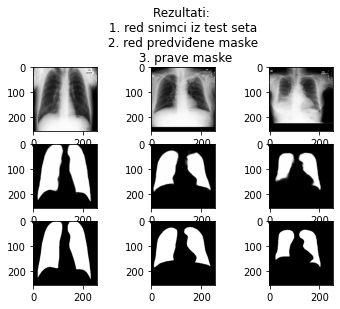

In [36]:
pred0 = model2.predict(x_test_norm)[0]
pred1 = model2.predict(x_test_norm)[1]
pred2 = model2.predict(x_test_norm)[2]

plt.subplot(3, 3, 1)
plt.imshow(x_test_norm[0])

plt.subplot(3, 3, 2)
plt.imshow(x_test_norm[1])

plt.title('Rezultati: \n 1. red snimci iz test seta \n 2. red predviđene maske \n 3. prave maske')

plt.subplot(3, 3, 3)
plt.imshow(x_test_norm[2])

plt.subplot(3, 3, 4)
plt.imshow(pred0)

plt.subplot(3, 3, 5)
plt.imshow(pred1)

plt.subplot(3, 3, 6)
plt.imshow(pred2)

plt.subplot(3, 3, 7)
plt.imshow(y_test[0])

plt.subplot(3, 3, 8)
plt.imshow(y_test[1])

plt.subplot(3, 3, 9)
plt.imshow(y_test[2])

plt.show() 

In [ ]:
model2.save_weights('model2')